# Estimating Gestational Diabetes Onset
### Reverse Timeseries Forecasting

## Pre-processing: Daily dataset - Averages

<ul>
	<li><a href="#Imports"><strong>Imports</strong></a></li>
	<li><a href="#Notebook-Settings"><strong>Notebook Settings</a></li>
	<li><a href="#Load-the-data"><strong>Loading the data</strong></a>
		<ul>
			<li>Setting the index</li>
			<li>Reverse the timeseries</li>
		</ul>
	</li>
    <li><a href="#Visualize"><strong>Visualize</strong></a>
		<ul>
			<li>Seasonal Decompose</li>
		</ul>
	</li>
    <li><a href="#Stationarity"><strong>Stationarity</strong></a>
		<ul>
			<li>Dickey Fuller Test</li>
		</ul>
	</li>
    <li><a href="#ACF-and-PACF"><strong>ACF and PACF</strong></a></li>
    <li><a href="#Model-1:-ARIMA"><strong>Model 1: ARIMA</strong></a>
		<ul>
            <li>Finding ARIMA Parameters</li>
            <li>Predictions</li>
		</ul>
    </li>
    <li><a href="#Model-1:-ARIMA"><strong>ARIMA attempt 2</strong></a>
    </li>
    <li><a href="#Model-2:-auto_arima"><strong>Model 2: auto_arima</strong></a></li>
    <li><a href="#Model-Comparisons"><strong>Model Comparisons</strong></a></li>
</ul>


### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error

from library.functions import jlcap_optimize_arima

### Notebook Settings

In [2]:
pd.set_option('display.max_rows', 500)

### Load the data

In [3]:
y = pd.read_csv('data/data_avg_pre-processed.csv')
y.set_index('date_forward', inplace=True)

In [4]:
y.head()

,bg_avg
date_forward,
2021-03-11,114
2021-03-12,112
2021-03-13,110
2021-03-14,126
2021-03-15,111


In [5]:
y.index = pd.DatetimeIndex(y.index, freq="D")
y.index

DatetimeIndex(['2021-03-11', '2021-03-12', '2021-03-13', '2021-03-14',
               '2021-03-15', '2021-03-16', '2021-03-17', '2021-03-18',
               '2021-03-19', '2021-03-20', '2021-03-21', '2021-03-22',
               '2021-03-23', '2021-03-24', '2021-03-25', '2021-03-26',
               '2021-03-27', '2021-03-28', '2021-03-29', '2021-03-30',
               '2021-03-31', '2021-04-01', '2021-04-02', '2021-04-03',
               '2021-04-04', '2021-04-05', '2021-04-06', '2021-04-07',
               '2021-04-08', '2021-04-09', '2021-04-10', '2021-04-11',
               '2021-04-12', '2021-04-13', '2021-04-14', '2021-04-15',
               '2021-04-16', '2021-04-17', '2021-04-18', '2021-04-19',
               '2021-04-20', '2021-04-21', '2021-04-22', '2021-04-23',
               '2021-04-24', '2021-04-25', '2021-04-26', '2021-04-27',
               '2021-04-28', '2021-04-29', '2021-04-30', '2021-05-01',
               '2021-05-02', '2021-05-03', '2021-05-04', '2021-05-05',
      

### Split Data into Training and Testing Sets

In [6]:
len(y)

74

In [7]:
split = int(np.floor(len(y)*.8))
split

59

In [8]:
y_train = y[:split]
y_test = y[split:]

In [9]:
y_train.shape, y_test.shape

((59, 1), (15, 1))

## Model 1: ARIMA

### Finding ARIMA Parameters

In [10]:
ps = range(0,8)
qs = range(0,8)

params = jlcap_optimize_arima(y_train, ps, qs, d=0)
params

,Order,AIC
0,"(0, 0, 7)",411.538806
1,"(3, 0, 3)",412.252132
2,"(0, 0, 0)",412.969429


### Fitting a Model

In [11]:
mod = ARIMA(y_train, order=(0,0,7))
res = mod.fit()

print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                 bg_avg   No. Observations:                   59
Model:                 ARIMA(0, 0, 7)   Log Likelihood                -196.769
Date:                Wed, 09 Mar 2022   AIC                            411.539
Time:                        11:53:41   BIC                            430.237
Sample:                    03-11-2021   HQIC                           418.838
                         - 05-08-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        112.8440      2.119     53.248      0.000     108.690     116.998
ma.L1          0.0238      0.380      0.063      0.950      -0.721       0.768
ma.L2          0.1521      0.371      0.410      0.6

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


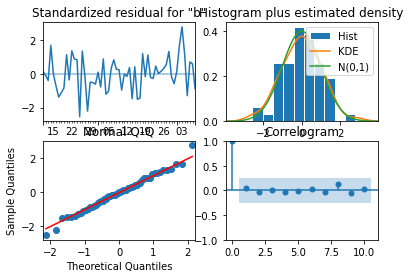

In [12]:
res.plot_diagnostics()
plt.show()

**Predictions**

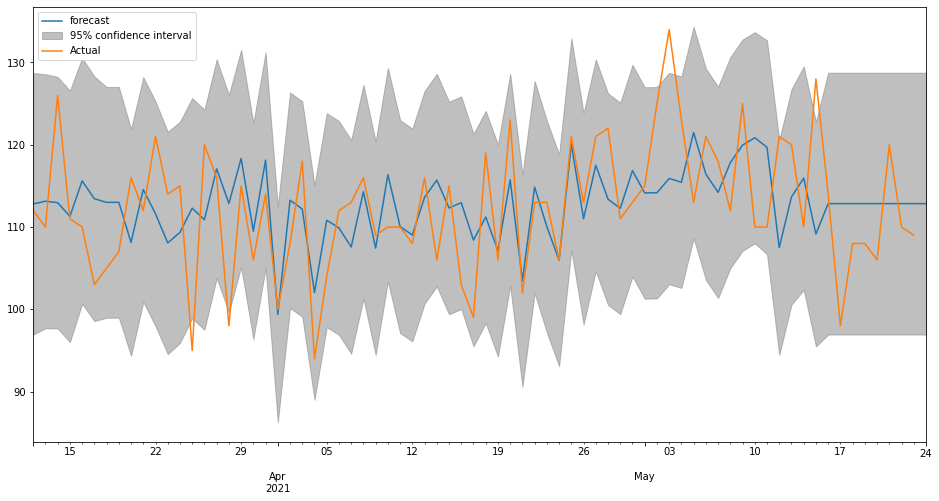

In [13]:
fig, ax = plt.subplots(figsize=(16, 8))

fig = plot_predict(res, start="2021-03-12", end="2021-05-24", ax=ax)
ax.plot(y, label='Actual')
legend = ax.legend(loc="upper left")

In [14]:
predictions = res.forecast(steps=len(y_test))
predictions.rename('bg_fasting', inplace=True)

2021-05-09    119.951998
2021-05-10    120.847361
2021-05-11    119.685581
2021-05-12    107.510056
2021-05-13    113.661088
2021-05-14    115.937964
2021-05-15    109.145462
2021-05-16    112.843955
2021-05-17    112.843955
2021-05-18    112.843955
2021-05-19    112.843955
2021-05-20    112.843955
2021-05-21    112.843955
2021-05-22    112.843955
2021-05-23    112.843955
Freq: D, Name: bg_fasting, dtype: float64

In [15]:
y_pred = pd.DataFrame(predictions)
y_pred.tail()

,bg_fasting
2021-05-19,112.843955
2021-05-20,112.843955
2021-05-21,112.843955
2021-05-22,112.843955
2021-05-23,112.843955


<AxesSubplot:xlabel='date_forward'>

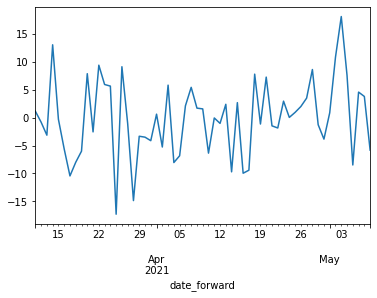

In [16]:
res.resid.plot()

In [34]:
rmse_arima = mean_squared_error(y_test, y_pred, squared=False)

print("Auto Arima RMSE: %.3f" % rmse_arima)

Auto Arima RMSE: 9.090


In [18]:
res_conf_int = res.conf_int()
res_conf_int

,0,1
const,108.690339,116.997571
ma.L1,-0.720758,0.768396
ma.L2,-0.575414,0.879608
ma.L3,-0.751291,0.960187
ma.L4,-0.697086,0.841600
ma.L5,-0.656399,1.240556
ma.L6,-0.815347,0.562096
ma.L7,0.009292,1.274630
sigma2,10.639364,74.176125


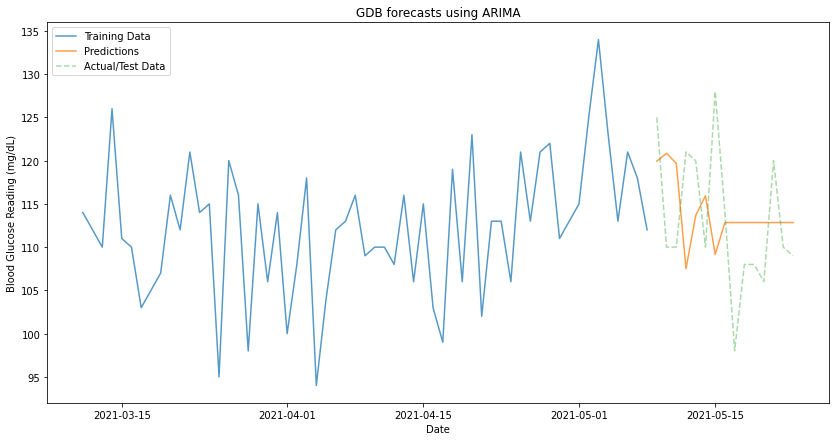

In [19]:
# Plot the points and the forecasts
training_days = pd.Series(y_train.index)
testing_days = pd.Series(y_test.index)

plt.figure(figsize=(14,7))

plt.plot(training_days, y_train, alpha=0.75, label='Training Data')
plt.plot(testing_days, y_pred, alpha=0.75, label='Predictions')  # Forecasts
plt.plot(testing_days, y_test,
            alpha=0.4, linestyle='--', label='Actual/Test Data')  # Test data
# plt.fill_between(testing_days, res_conf_int[:, 0], res_conf_int[:, 1], alpha=0.1, color='b')

plt.title("GDB forecasts using ARIMA")
plt.xlabel("Date")
plt.ylabel("Blood Glucose Reading (mg/dL)")
plt.legend(loc='upper left')

plt.savefig('vis/arima_avg_pred_vs_test.png', bbox_inches="tight")
plt.show()

### ARIMA attempt 2
**The arima order with the lowest AIC has quite a bit of smoothing, which is affecting the prediction more than I like, so let's try the next order**

In [20]:
mod_2 = ARIMA(y_train, order=(3,0,3))
res_2 = mod_2.fit()

print(res_2.summary())

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                 bg_avg   No. Observations:                   59
Model:                 ARIMA(3, 0, 3)   Log Likelihood                -198.126
Date:                Wed, 09 Mar 2022   AIC                            412.252
Time:                        11:53:43   BIC                            428.872
Sample:                    03-11-2021   HQIC                           418.740
                         - 05-08-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        112.7030      2.377     47.424      0.000     108.045     117.361
ar.L1         -0.6919      0.256     -2.699      0.007      -1.194      -0.189
ar.L2          0.4514      0.384      1.177      0.2

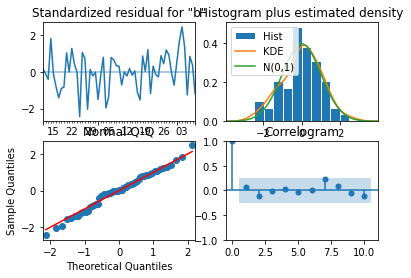

In [21]:
res_2.plot_diagnostics()
plt.show()

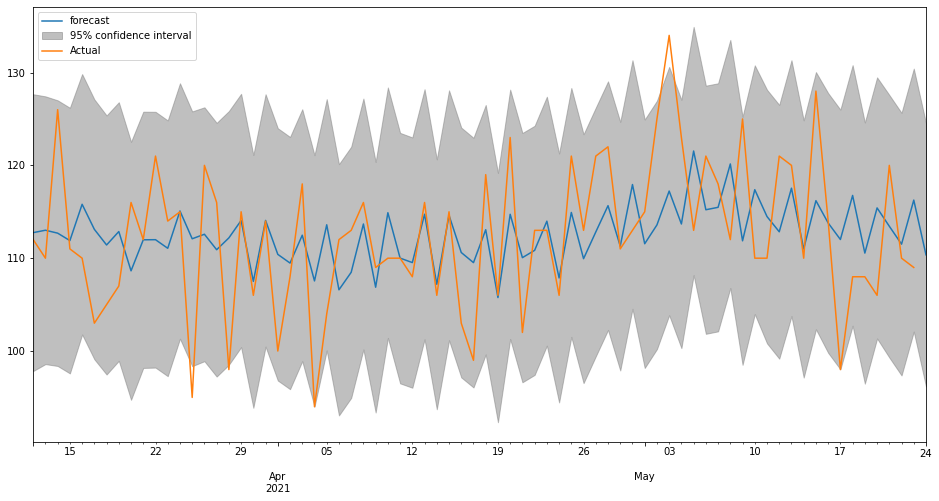

In [22]:
fig, ax = plt.subplots(figsize=(16, 8))

fig = plot_predict(res_2, start="2021-03-12", end="2021-05-24", ax=ax)
ax.plot(y, label='Actual')
legend = ax.legend(loc="upper left")

In [23]:
predictions_2 = res_2.forecast(steps=len(y_test))
predictions_2.rename('bg_avg', inplace=True)
y_pred_2 = pd.DataFrame(predictions_2)
y_pred_2.tail()

,bg_avg
2021-05-19,110.549972
2021-05-20,115.414861
2021-05-21,113.441845
2021-05-22,111.512424
2021-05-23,116.257882


<AxesSubplot:xlabel='date_forward'>

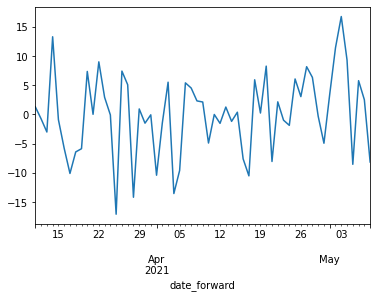

In [24]:
res_2.resid.plot()

In [33]:
rmse_arima_2 = mean_squared_error(y_test, y_pred_2, squared=False)

print("Auto Arima RMSE: %.3f" % rmse_arima_2)

Auto Arima RMSE: 7.857


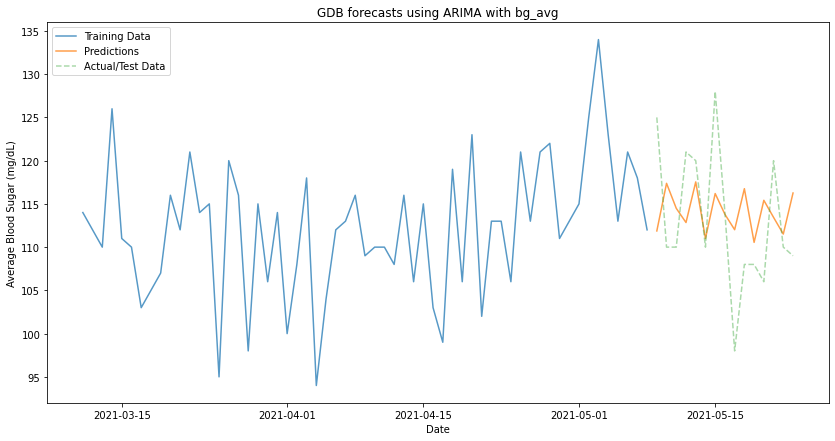

In [26]:
plt.figure(figsize=(14,7))

plt.plot(training_days, y_train, alpha=0.75, label='Training Data')
plt.plot(testing_days, y_pred_2, alpha=0.75, label='Predictions')  # Predictions
plt.plot(testing_days, y_test,
            alpha=0.4, linestyle='--', label='Actual/Test Data')  # Test data

plt.title("GDB forecasts using ARIMA with bg_avg")
plt.xlabel("Date")
plt.ylabel("Average Blood Sugar (mg/dL)")
plt.legend(loc='upper left')

plt.savefig('vis/arima_avg_2_pred_vs_test.png', bbox_inches="tight")
plt.show()

## Model 2: auto_arima

In [27]:
# Fit a simple auto_arima model
mod_auto = auto_arima(y_train, start_p=0, start_q=0,
                     max_p=10, max_q=10,
                     stepwise=True, suppress_warnings=True,
                     error_action='ignore')

mod_auto.order

(0, 1, 1)

In [28]:
mod_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -200.952
Date:                Wed, 09 Mar 2022   AIC                            405.904
Time:                        11:53:44   BIC                            410.024
Sample:                             0   HQIC                           407.509
                                 - 59                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8655      0.082    -10.555      0.000      -1.026      -0.705
sigma2        58.4203     11.681      5.001      0.000      35.525      81.315
===================================================================================
Ljung-Box (L1) (Q):                   0.96   Jarque-Bera (JB):                 0.28
Prob(Q):                              0.33   Prob(JB):                         0.87
Heteroskedasticity (H):               1.00   Skew:                            -0.15
Prob(H) (two-sided):                  0.99   Kurtosis:                         2.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
preds, conf_int = mod_auto.predict(n_periods=y_test.shape[0], return_conf_int=True)

rmse_auto_arima = np.sqrt(mean_squared_error(y_test, preds))
print("Auto Arima RMSE: %.3f" % rmse_auto_arima)

Auto Arima RMSE: 8.848


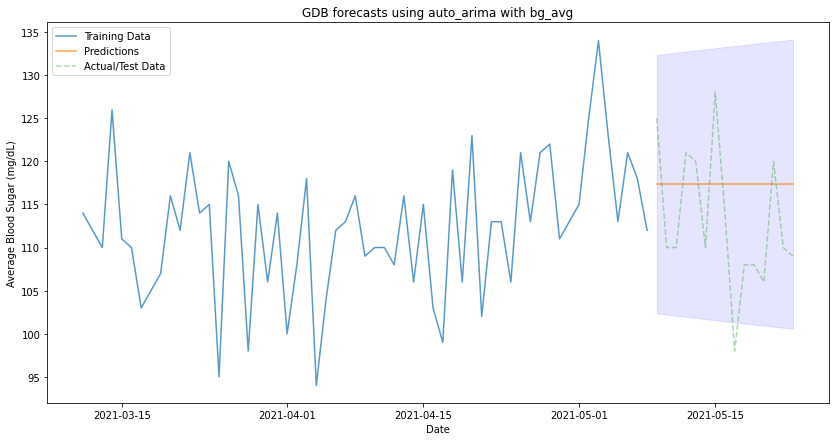

In [30]:
# Plot the points and the forecasts
training_days = pd.Series(y_train.index)
testing_days = pd.Series(y_test.index)

plt.figure(figsize=(14,7))

plt.plot(training_days, y_train, alpha=0.75, label='Training Data')
plt.plot(testing_days, preds, alpha=0.75, label='Predictions')  # Forecasts
plt.plot(testing_days, y_test,
            alpha=0.4, linestyle='--', label='Actual/Test Data')  # Test data
plt.fill_between(testing_days,
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b')

plt.title("GDB forecasts using auto_arima with bg_avg")
plt.xlabel("Date")
plt.ylabel("Average Blood Sugar (mg/dL)")
plt.legend(loc='upper left')

plt.savefig('vis/auto_arima_avg_pred_vs_test.png', bbox_inches="tight")
plt.show()

### Model Comparisons

In [47]:
std_test = np.std(y_test.values)
std_test

7.779174477767905

In [49]:
model_scores = pd.DataFrame({
	'RMSE': [rmse_arima, rmse_arima_2, rmse_auto_arima], 
    'Standardized': [rmse_arima/std_test, rmse_arima_2/std_test, rmse_auto_arima/std_test]},
	index=['ARIMA (0, 0, 7)', 'ARIMA (3, 0, 3)', 'Auto Arima'])
model_scores

,RMSE,Standardized
"ARIMA (0, 0, 7)",9.089890,1.168490
"ARIMA (3, 0, 3)",7.857382,1.010054
Auto Arima,8.848146,1.137414


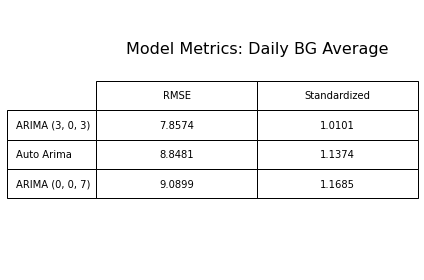

In [93]:
model_scores.sort_values(by='RMSE', inplace=True)

fig, ax = plt.subplots()

fig.patch.set_visible(False)
ax.axis('off')

table = ax.table(
    cellText=np.round(model_scores.values,4), 
    colLabels=model_scores.columns, 
    rowLabels=model_scores.index, 
    loc='center', 
    cellLoc='center'
)

table.scale(1, 2)

plt.title('Model Metrics: Daily BG Average', size=16, y=.8)
plt.tight_layout(h_pad=2)

plt.show()

fig.savefig('vis/daily_avg_model_metrics.png', bbox_inches="tight")
